In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Read in the data
df = pd.read_parquet('../data/transformed/ace_full_data.parquet', engine='pyarrow')

In [15]:
# Columns in the data
df.columns

Index(['Year', 'Day', 'Hour', 'Minute', 'points_in_IMF_avgs',
       'Percent_interp.', 'CP/MV_Flag', 'Timeshift_sec', 'Phase_frnt_nrml_X',
       'Phase_frnt_nrml_Y', 'Phase_frnt_nrml_Z', 'ScalarB_nT', 'Bx_nT_GSE_GSM',
       'By_nT_GSE', 'Bz_nT_GSE', 'By_nT_GSM', 'Bz_nT_GSM', 'RMS_timeshift_sec',
       'RMS_phase_front_normal', 'RMS_ScalarB_nT', 'RMS_Field vector_nT',
       'points_in_plasma_avgs', 'Flow_speed_kms', 'Vx_Velocity_kms_GSE',
       'Vy_Velocity_kms_GSE', 'Vz_Velocity_kms_GSE', 'Proton_Density_ncc',
       'Temperature_K', 'X_sc_GSE_Re', 'Y_sc_GSE_Re', 'Z_sc_GSE_Re',
       'X_target_GSE_Re', 'Y_target_GSE_Re', 'Z_target_GSE_Re',
       'RMS_target_Re', 'DBOT1_sec', 'DBOT2_sec'],
      dtype='object')

Only couple of features(columns) are crucial for our analysis.
The features are: 
**Vx_Velocity_kms_GSE** (Velocity of the solar wind in km/s) \
**Bz_nT_GSM**(Magnetic field in nT) \
**Proton_Density_ncc** (Proton density in n/cc)."



Lets see how our data for futher analysis looks like

In [33]:
columns_of_interest = ['Bz_nT_GSM', 'Vx_Velocity_kms_GSE', 'Proton_Density_ncc']
df[columns_of_interest].head(20)

,Bz_nT_GSM,Vx_Velocity_kms_GSE,Proton_Density_ncc
0,9999.99,99999.9,999.99
1,9999.99,99999.9,999.99
2,9999.99,99999.9,999.99
3,9999.99,99999.9,999.99
4,9999.99,99999.9,999.99
5,9999.99,99999.9,999.99
6,9999.99,99999.9,999.99
7,9999.99,99999.9,999.99
8,9999.99,99999.9,999.99
9,9999.99,99999.9,999.99


We can see missing values in the data(high values only with nines).
It can be for a variety of reasons, for example, the spacecraft was not working at that time.
First we need to chage this values for NaN - not a number format. It will prevent our analysis from strange results as values like that are clearly not real.

In [37]:
# Explicitly replace the identified anomalous values with NaN
df['Bz_nT_GSM'] = df['Bz_nT_GSM'].replace(9999.99, np.nan)
df['Vx_Velocity_kms_GSE'] = df['Vx_Velocity_kms_GSE'].replace(99999.9, np.nan)
df['Proton_Density_ncc'] = df['Proton_Density_ncc'].replace(999.99, np.nan)

# Display the cleaned data for verification
df[columns_of_interest].head()


,Bz_nT_GSM,Vx_Velocity_kms_GSE,Proton_Density_ncc
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


We changed missing values to NaN, so we can proceed with our analysis

First lets analyse the Bz data, as this is the most important for predicting the magnetic reconnection events.

## Bz analysis

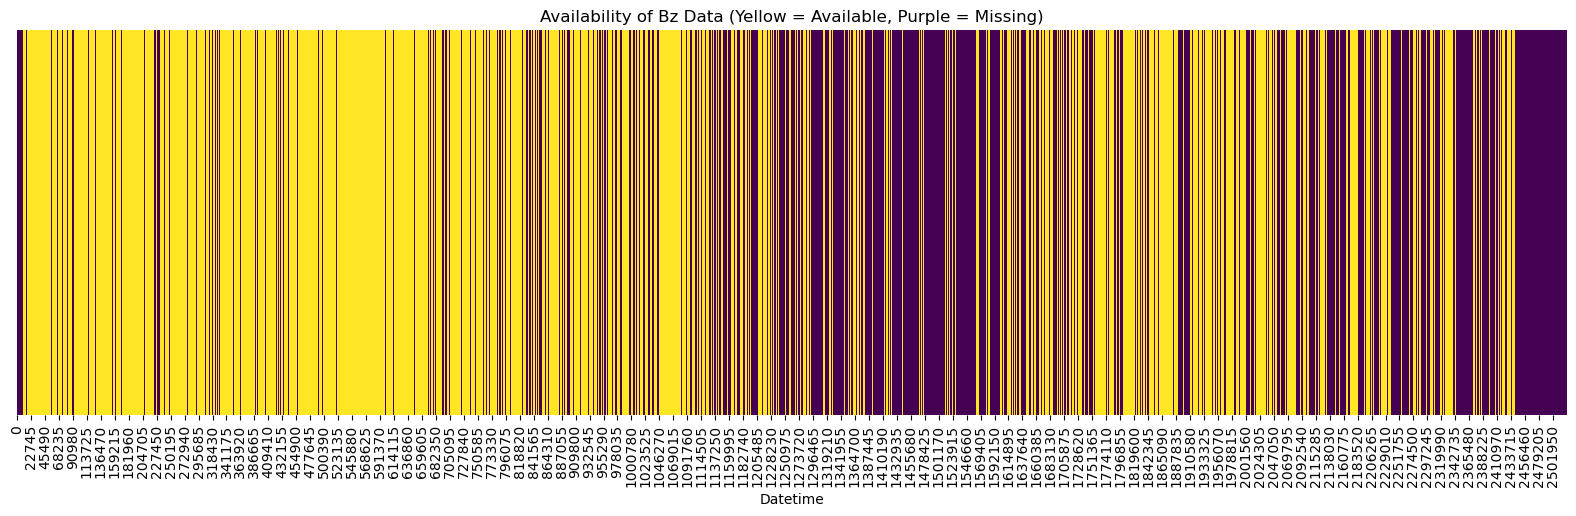

In [42]:
# Create a binary column for the presence of Bz data (1 if data is available, 0 if missing)
df['Bz_Present'] = ~df['Bz_nT_GSM'].isna() * 1

# Heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(df[['Bz_Present']].T, cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Datetime')
plt.title('Availability of Bz Data (Yellow = Available, Purple = Missing)')
plt.show()


We can see that sometimes we have a lot of missing data. Let's see how values of Bz are distributed.

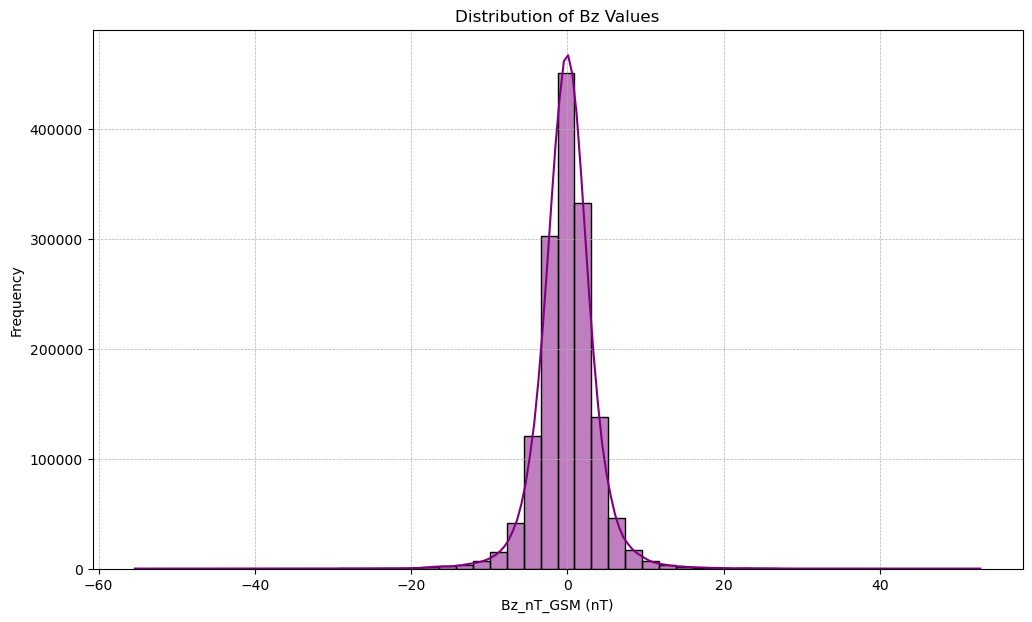

In [43]:
# Histogram for Bz values
plt.figure(figsize=(12, 7))
sns.histplot(df['Bz_nT_GSM'], bins=50, color='purple', kde=True)
plt.xlabel('Bz_nT_GSM (nT)')
plt.ylabel('Frequency')
plt.title('Distribution of Bz Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Bz values are dirbuted pretty evenly around 0. Lets see percetage of positive and negative values

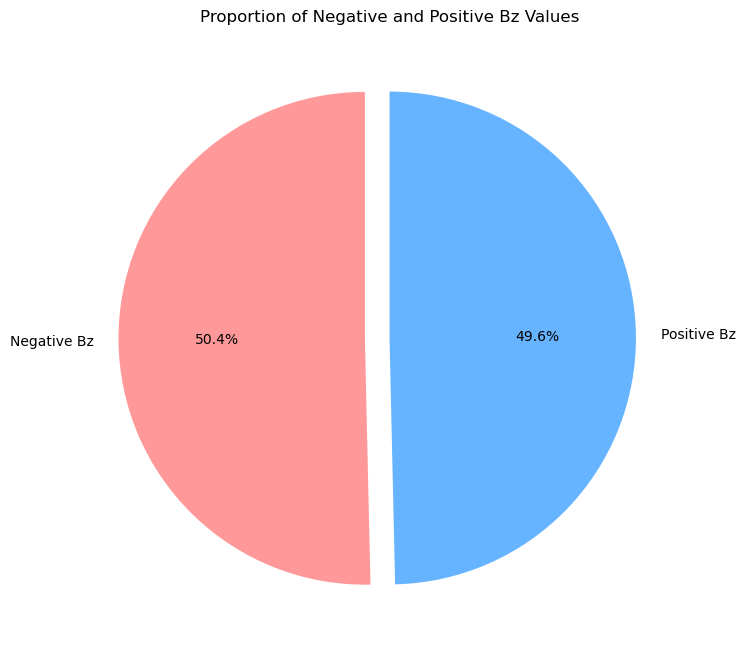

In [49]:
# Count the number of negative and positive Bz values
bz_negative_count = (df['Bz_nT_GSM'] < 0).sum()
bz_positive_count = (df['Bz_nT_GSM'] > 0).sum()

# Pie chart
labels = ['Negative Bz', 'Positive Bz']
sizes = [bz_negative_count, bz_positive_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice for emphasis

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Negative and Positive Bz Values')
plt.show()

Let's look at the negative distribution of Bz valuesb

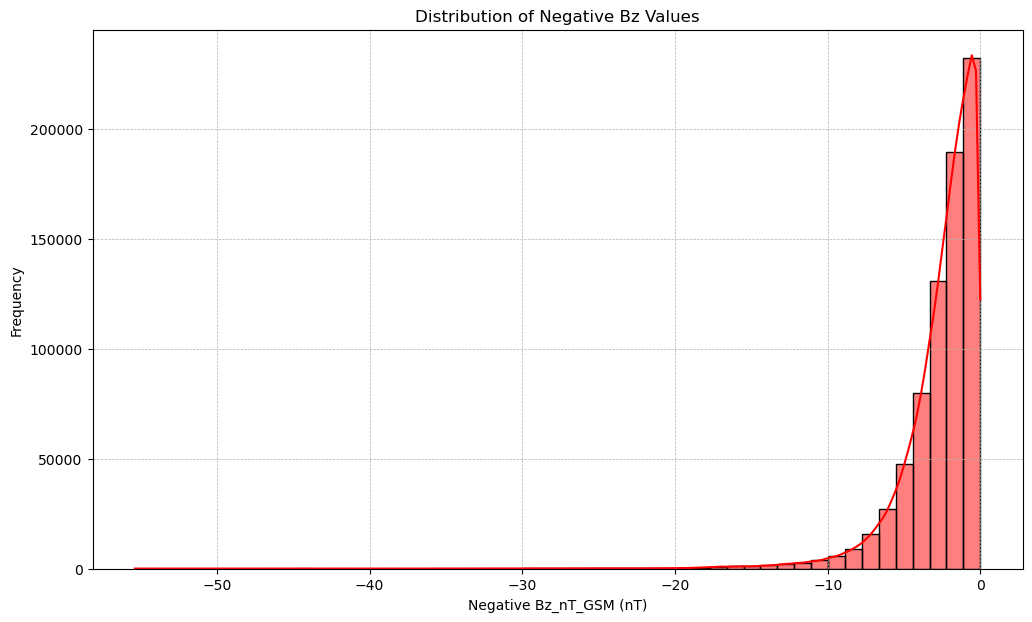

In [51]:
# Extract negative Bz values
negative_bz_values = df[df['Bz_nT_GSM'] < 0]['Bz_nT_GSM']

# Histogram for negative Bz values
plt.figure(figsize=(12, 7))
sns.histplot(negative_bz_values, bins=50, color='red', kde=True)
plt.xlabel('Negative Bz_nT_GSM (nT)')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Bz Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


The majority of negative Bz values cluster around −1 to −2 nT. \
The distribution is right-skewed, indicating that while most of the negative values are close to zero, there are occasional instances of strongly negative Bz values - which can lead to a magnetic storm

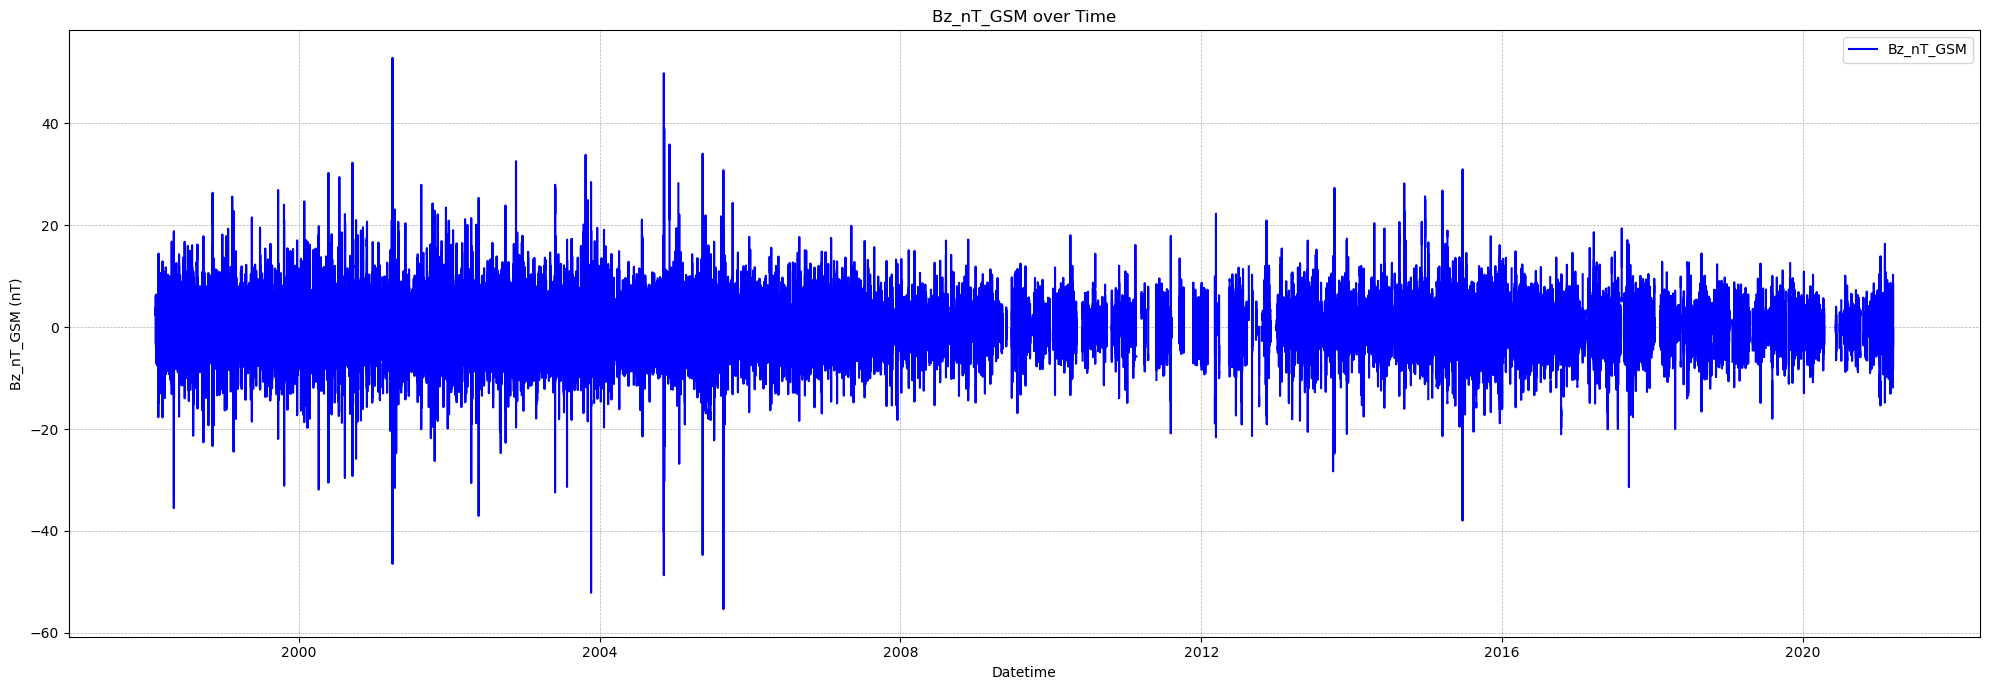

In [48]:
# Create datetime column
df['Datetime'] = pd.to_datetime(df['Year'].astype(str) + 
                                      df['Day'].astype(str).str.zfill(3), format='%Y%j') + \
                      pd.to_timedelta(df['Hour'], unit='h') + \
                      pd.to_timedelta(df['Minute'], unit='m')

# Plot Bz_nT_GSM over time
plt.figure(figsize=(20, 7))
plt.plot(df['Datetime'], df['Bz_nT_GSM'], color='blue', label='Bz_nT_GSM')
plt.xlabel('Datetime')
plt.ylabel('Bz_nT_GSM (nT)')
plt.title('Bz_nT_GSM over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


We have basic understanding of the Bz data. Now, let's look at the other variable of interest - Velocity_kms_GSE - Solar wind speed

### What threshold should we set for Bz value to look later for possible magnetic reconnection events?

The Bz component of the interplanetary magnetic field (IMF) is of particular interest because a southward (negative) Bz enhances the potential for magnetic reconnection at Earth's magnetopause. A southward IMF can connect with Earth's northward magnetic field, facilitating reconnection.

To identify periods where Bz is notably southward, we examine the statistical distribution of Bz values. The 25th percentile value represents a point below which 25% of the Bz data falls. 

In [68]:
# Calculate descriptive statistics for Bz values
bz_stats = df['Bz_nT_GSM'].describe()
bz_threshold_value = bz_stats['25%']
bz_threshold_value

-1.94

By using this as our threshold, we're focusing on the lower quartile of Bz values, representing more pronounced southward magnetic field directions which are more likely to be associated with magnetic reconnection.



## Solar wind speed (Vx_Velocity_kms_GSE) analysis

First, we let's see missing data

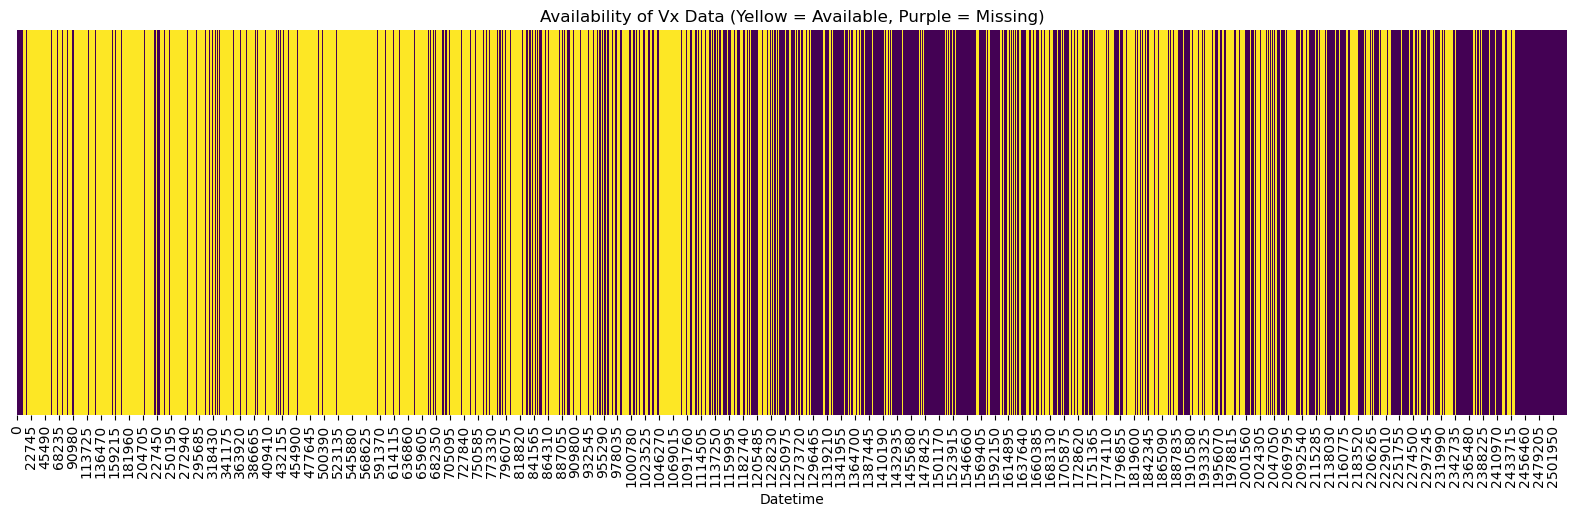

In [54]:
# Create a binary column for the presence of Vx data (1 if data is available, 0 if missing)
df['Vx_Present'] = ~df['Vx_Velocity_kms_GSE'].isna() * 1

# Heatmap for Vx data availability
plt.figure(figsize=(20, 5))
sns.heatmap(df[['Vx_Present']].T, cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Datetime')
plt.title('Availability of Vx Data (Yellow = Available, Purple = Missing)')
plt.show()

Yellow represents available data. Purple represents missing data. Similiar periods of missing data as for Bz value.


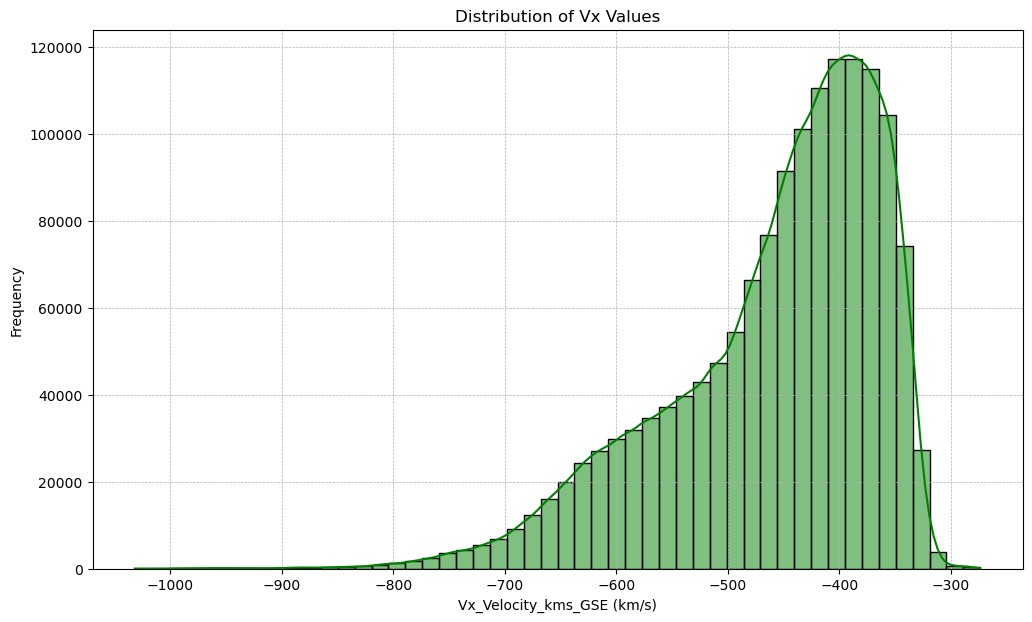

In [56]:
#  Histogram for Vx values
plt.figure(figsize=(12, 7))
sns.histplot(df['Vx_Velocity_kms_GSE'], bins=50, color='green', kde=True)
plt.xlabel('Vx_Velocity_kms_GSE (km/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Vx Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Most of the \( Vx \) values cluster around \(-400\) km/s. 
The distribution is slightly right-skewed, indicating that while most of the values are negative, there are occasional instances of values closer to zero. 


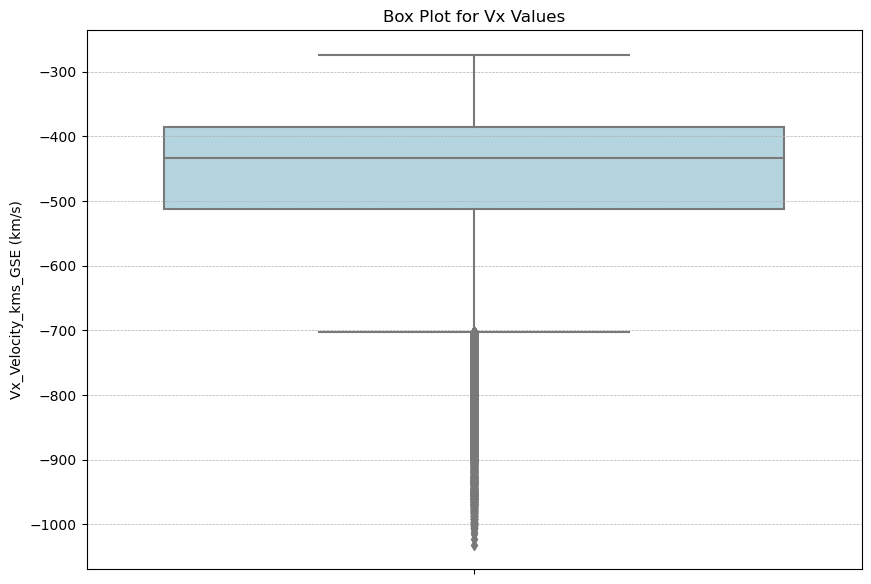

In [57]:
# 1. Box Plot for Vx values
plt.figure(figsize=(10, 7))
sns.boxplot(y=df['Vx_Velocity_kms_GSE'], color='lightblue')
plt.ylabel('Vx_Velocity_kms_GSE (km/s)')
plt.title('Box Plot for Vx Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.show()


The median (the line inside the box) is around −400 km/s.
The interquartile range (the height of the box) shows the middle 50% of the data.
The whiskers (the lines extending from the box) show the range of the data, excluding potential outliers.


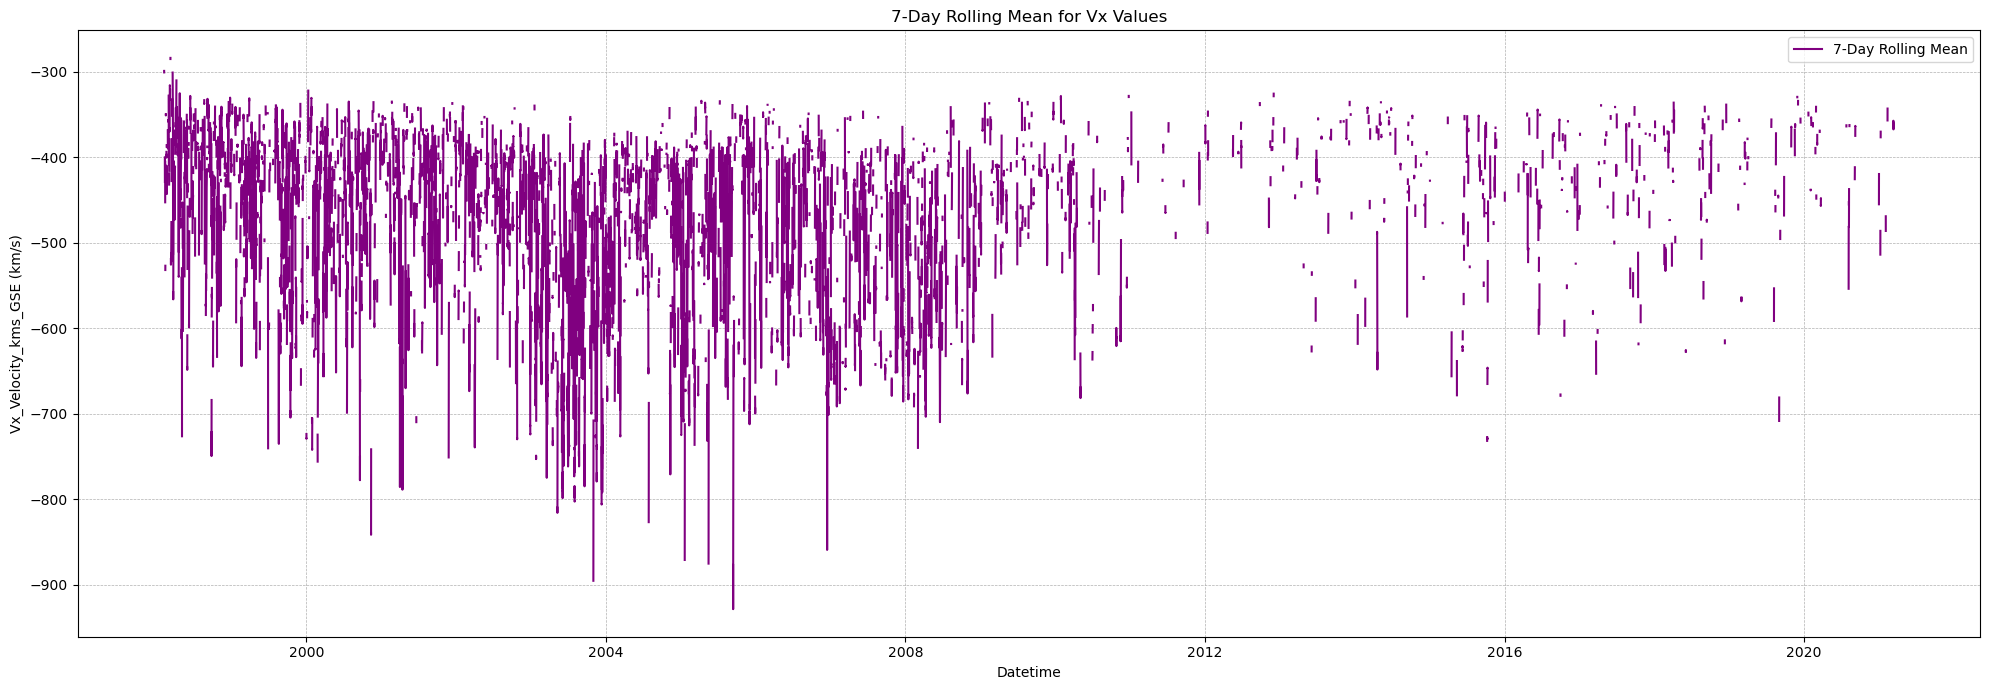

In [58]:
rolling_mean = df['Vx_Velocity_kms_GSE'].rolling(window=7*24).mean()  # 7 days * 24 hours

plt.figure(figsize=(20, 7))
plt.plot(df['Datetime'], rolling_mean, color='purple', label='7-Day Rolling Mean')
plt.xlabel('Datetime')
plt.ylabel('Vx_Velocity_kms_GSE (km/s)')
plt.title('7-Day Rolling Mean for Vx Values')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### What threshold should we set for solar wind speed value to look later for possible magnetic reconnection events?

The speed of the solar wind can influence the rate of magnetic reconnection. High solar wind speeds can enhance the rate of magnetic reconnection by driving more solar wind plasma into Earth's magnetosphere, causing increased compression.

In [76]:
# Calculate descriptive statistics for solar wind speed values
vx_stats = ace_data['Vx_Velocity_kms_GSE'].describe()
vx_threshold_value = vx_stats['75%']
vx_threshold_value

-385.1

By examining the statistical distribution of solar wind speed values, we can identify periods with notably high speeds. The 75th percentile value represents a point below which 75% of the data falls. We use lowest values, because wind speed in our dataset is noted in negative km/s. Later we will use absolute values of wind speed.

## Proton density analysis

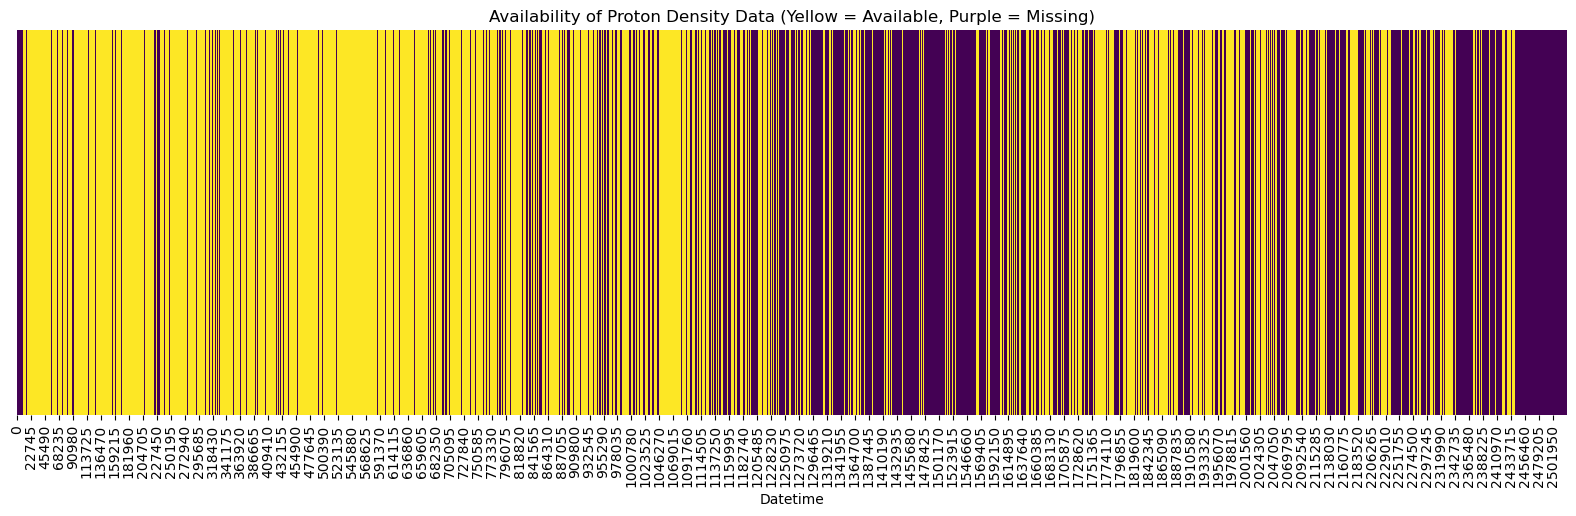

In [84]:
# Create a binary column for the presence of Proton Density data (1 if data is available, 0 if missing)
df['Proton_Density_Present'] = ~df['Proton_Density_ncc'].isna() * 1

# Heatmap for Proton Density data availability
plt.figure(figsize=(20, 5))
sns.heatmap(df[['Proton_Density_Present']].T, cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Datetime')
plt.title('Availability of Proton Density Data (Yellow = Available, Purple = Missing)')
plt.show()



Distribution of Proton Density values

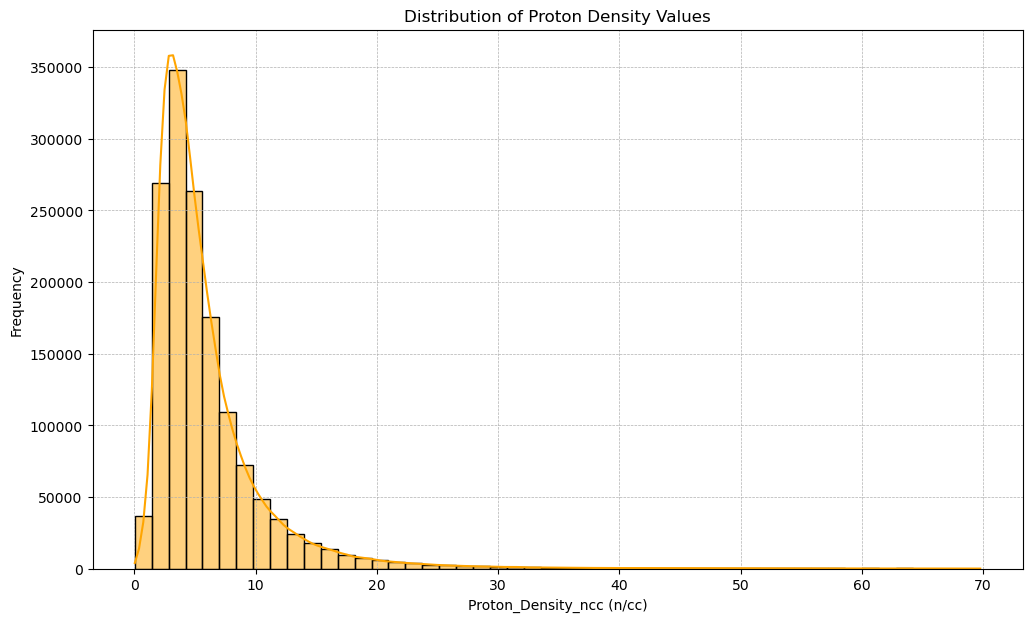

In [61]:
# Histogram for Proton Density values
plt.figure(figsize=(12, 7))
sns.histplot(df['Proton_Density_ncc'], bins=50, color='orange', kde=True)
plt.xlabel('Proton_Density_ncc (n/cc)')
plt.ylabel('Frequency')
plt.title('Distribution of Proton Density Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


The majority of proton density values cluster around the 5-10 n/cc range.
There are peaks observed in the distribution, indicating specific ranges where the proton density frequently occurs.
The distribution also has a long tail, indicating the presence of higher-density values, though they are less frequent.

### From the plots, we can observe periods where Bz is negative, absolute solar wind speeds are high, and proton densities show variations. These periods may be favorable for magnetic reconnection.


In [74]:
vx_threshold_value

In [78]:
# Calculate the statistical summary for proton density to determine its threshold
proton_density_stats = df['Proton_Density_ncc'].describe()

# Determine threshold for proton density deviations (e.g., more than 1 standard deviation from the mean)
proton_density_upper_threshold = proton_density_stats['mean'] + proton_density_stats['std']
proton_density_lower_threshold = proton_density_stats['mean'] - proton_density_stats['std']
df['Abs_Vx_Velocity_kms_GSE'] = df['Vx_Velocity_kms_GSE'].abs()
# Identify periods where all three conditions are met
reconnection_periods = df[
    (df['Bz_nT_GSM'] < bz_threshold_value) &
    (df['Abs_Vx_Velocity_kms_GSE'] > abs(vx_threshold_value)) &
    ((df['Proton_Density_ncc'] > proton_density_upper_threshold) | 
     (df['Proton_Density_ncc'] < proton_density_lower_threshold))
]

# Display the identified periods of interest
reconnection_periods[['Datetime', 'Bz_nT_GSM', 'Abs_Vx_Velocity_kms_GSE', 'Proton_Density_ncc']]


,Datetime,Bz_nT_GSM,Abs_Vx_Velocity_kms_GSE,Proton_Density_ncc
11178,1998-02-08 19:30:00,-2.79,386.7,19.62
11180,1998-02-08 19:40:00,-2.59,391.9,18.17
11181,1998-02-08 19:45:00,-4.88,394.2,16.56
11182,1998-02-08 19:50:00,-6.21,391.5,16.97
11183,1998-02-08 19:55:00,-6.25,393.9,16.23
...,...,...,...,...
2440124,2021-03-13 15:40:00,-5.67,448.1,11.80
2440125,2021-03-13 15:45:00,-5.36,447.1,12.57
2440126,2021-03-13 15:50:00,-4.72,457.4,11.85
2440130,2021-03-13 16:10:00,-5.21,444.4,10.88


/tmp/ipykernel_53694/92691030.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Month', y='Count', data=aggregate_monthly_reconnection_counts, palette='viridis', ci=None)


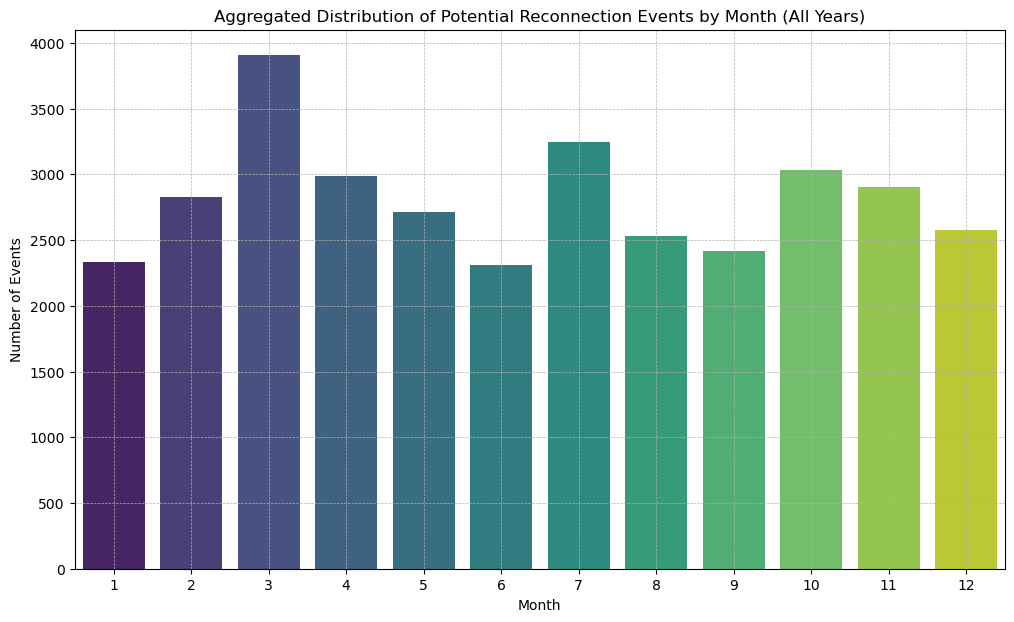

In [81]:
# Group by month alone (across all years) to get counts
aggregate_monthly_reconnection_counts = reconnection_periods.groupby(['Month']).size().reset_index(name='Count')

# Plot histogram of aggregated potential reconnection events by month
plt.figure(figsize=(12, 7))
sns.barplot(x='Month', y='Count', data=aggregate_monthly_reconnection_counts, palette='viridis', ci=None)
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.title('Aggregated Distribution of Potential Reconnection Events by Month (All Years)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


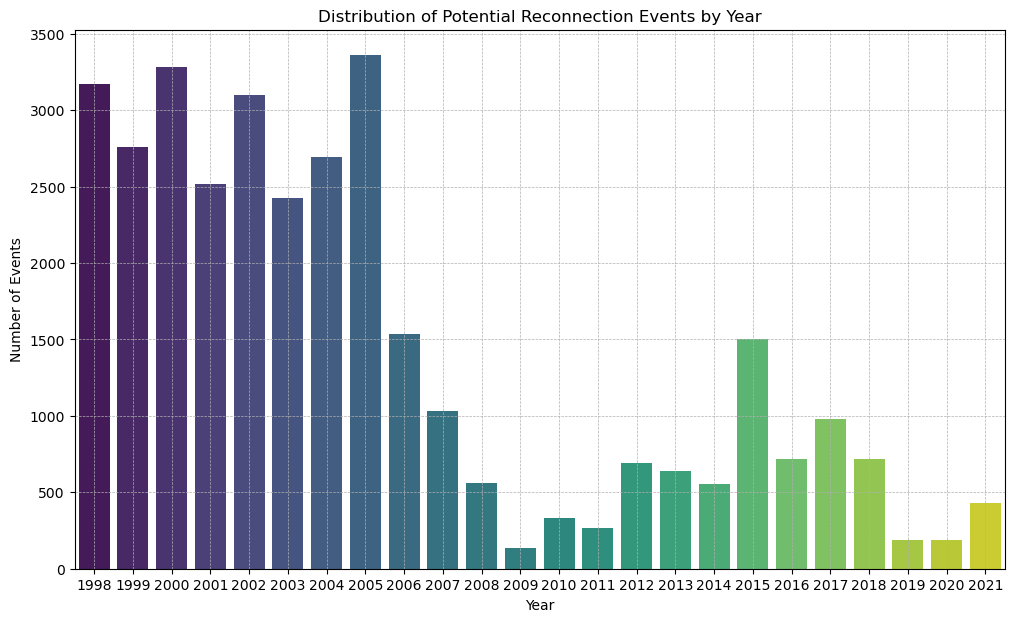

In [82]:
# Group by year to get counts
yearly_reconnection_counts = reconnection_periods.groupby(['Year']).size().reset_index(name='Count')

# Plot bar chart of potential reconnection events by year
plt.figure(figsize=(12, 7))
sns.barplot(x='Year', y='Count', data=yearly_reconnection_counts, palette='viridis')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Distribution of Potential Reconnection Events by Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


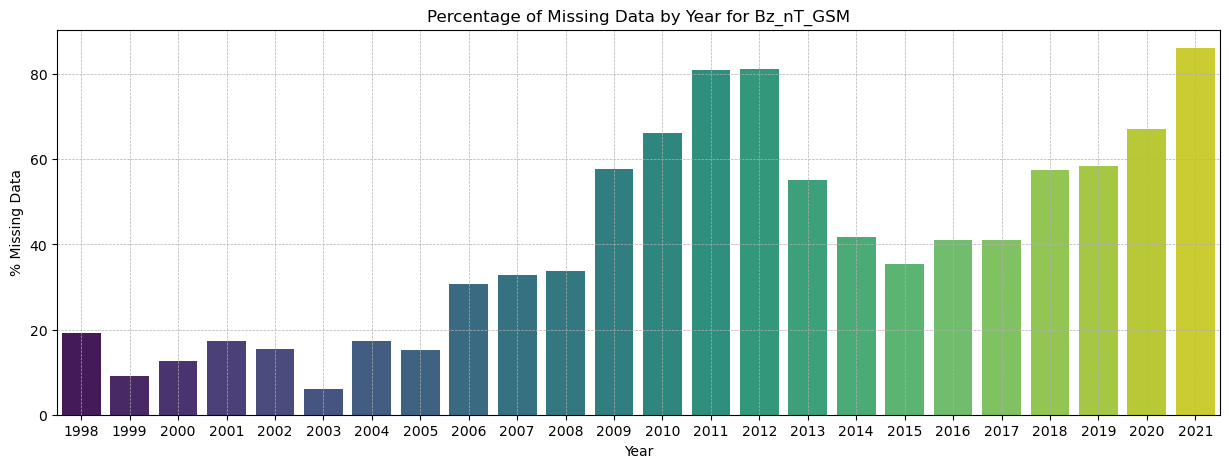

In [86]:
# Calculate the percentage of missing data for each year (avoiding 'Datetime' column duplication)
missing_data_percentage_yearly = df.set_index('Datetime').resample('Y').apply(lambda x: x.isnull().mean() * 100)

# Reset index for easier plotting
missing_data_percentage_yearly_reset = missing_data_percentage_yearly.reset_index()

# Plotting the percentage of missing data for each year for Bz_nT_GSM
plt.figure(figsize=(15, 5))
sns.barplot(x=missing_data_percentage_yearly_reset['Datetime'].dt.year, y='Bz_nT_GSM', data=missing_data_percentage_yearly_reset, palette='viridis')
plt.xlabel('Year')
plt.ylabel('% Missing Data')
plt.title('Percentage of Missing Data by Year for Bz_nT_GSM')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
